## Summary

### Definition of model

To the contrary of the model where the cells are divided into quadrants, the quadrants are joined with the neighbouring cells. This makes it so that the number of states are the same as the base model.

### Results

This works better: 15 or 20% percent convergence but we still see the action looping behavior.

In [1]:
import sys
sys.path.append('../../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent, QMDP_Agent, Infotaxis_Agent
from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet
from olfactory_navigation.simulation import run_test

from matplotlib import pyplot as plt
from matplotlib import colors, patches
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(2)

## Variables

In [3]:
# Space and cells
space_shape = np.array([101,101])
cells = np.array([9,9])

# Source
source_radius = 2

## Building probabilities

In [4]:
indices = np.arange(space_shape[0])
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal([50, 50], 50)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

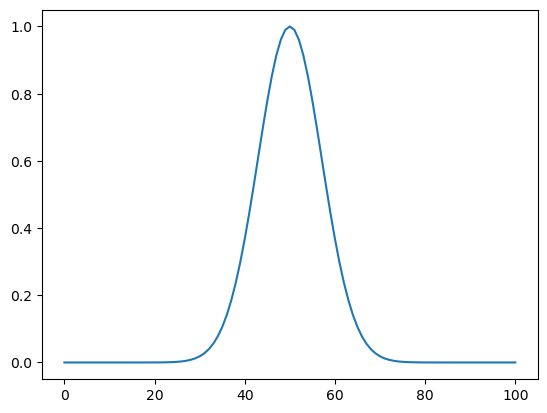

In [5]:
plt.plot(probability_map[50])

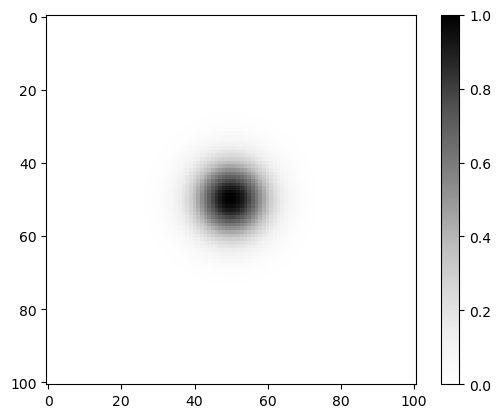

In [6]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

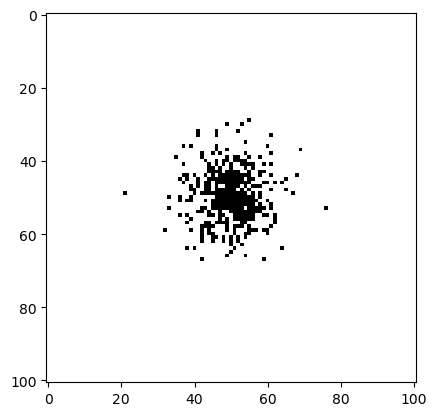

In [7]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

# Print sample
plt.imshow(multiple_samples[4], cmap='Greys')

## Model Definition

### Basic cells

In [8]:
def build_grid_mapping(space_shape: np.ndarray = np.array([101,101]),
                       cells: np.ndarray = np.array([3,3]),
                       source_position: np.ndarray = np.array([50,50]),
                       source_radius: int = 2
                       ) -> np.ndarray:
    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
    upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

    grid_cells = np.full(space_shape, -1)
    for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
        slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

        # Grid to cell mapping
        grid_cells[*slices] = i

    # Finding cell the replace
    source_cell_id = grid_cells[*source_position]
    source_cell = np.array(np.unravel_index(source_cell_id, cells))

    # Finding center and replacing with closest side
    source_cell_shape = np.array([sizes[int(ax_id)] for sizes, ax_id in zip(cell_sizes, source_cell)])
    source_in_source_cell = source_position - lower_bounds[source_cell_id]

    # Splitting the center cell grid into cardinal quarters
    array = np.zeros(source_cell_shape)

    # Finding indices
    indices_list = list(np.ndindex(array.shape))
    indices_array = np.array(indices_list)

    # From the indices finding the points and converting them to the imaginary grid
    points = indices_array - source_in_source_cell
    points_im = points[:,0] + (points[:,1] * 1j)

    # Shifting the points by 4 times by 90degrees and computing the angles
    shifted_points_im = points_im[:,None] * np.array([1, 1j, -1, -1j])
    angles = np.angle(shifted_points_im, deg=True)

    # Finding edge cells
    edge_cells = source_cell[None,:] + np.array([[1,0],[0,-1],[-1,0],[0,1]])
    edge_exists = np.all((edge_cells >= 0) & (edge_cells < cells), axis=1)
    edge_cells[~edge_exists] = source_cell[None,:]
    edge_cells_id = np.ravel_multi_index(edge_cells.T, cells)

    # Computing the closest quarter for each point and assigning it on the grid
    closest_quarter = np.argmin(np.abs(angles) + np.where(angles < 0, 0, 1), axis=1)
    array[*indices_array.T] = edge_cells_id[closest_quarter]
    # array[*indices_array.T] = (np.arange(4) + np.prod(cells))[closest_quarter]

    # Inserting in the grid
    source_cell_slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_bounds[source_cell_id], upper_bounds[source_cell_id])]
    grid_cells[*source_cell_slices] = array

    # Spacial indices
    spacial_indices = list(np.ndindex(tuple(space_shape)))
    spacial_indices_array = np.array(spacial_indices).astype(int)

    # Indices are at source
    at_source = np.sum((source_position[None,:] - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
    grid_cells[*spacial_indices_array[at_source].T] = -1

    return grid_cells

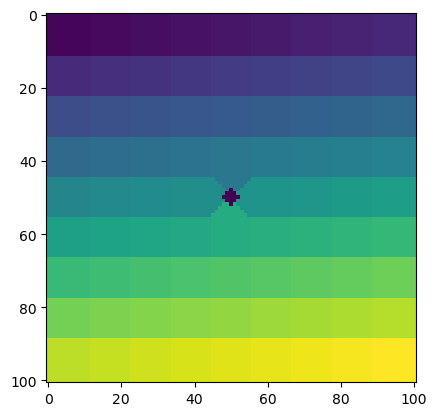

In [9]:
# grid_cells = build_grid_mapping(source_position=np.array([20,20]))
# grid_cells = build_grid_mapping(cells=np.array([9,9]))
# grid_cells = build_grid_mapping()
grid_cells = build_grid_mapping(space_shape=space_shape, cells=cells, source_position=np.floor(space_shape/2).astype(int))

# Visualize
plt.imshow(grid_cells)
plt.show()

### State labels

In [10]:
# Get the list of all indices
indices_list = list(np.ndindex((*cells, *cells)))

# Print the indices list
state_labels = [f's_{s_y}_{s_x}-a_{a_y}_{a_x}' for (s_y, s_x, a_y, a_x) in indices_list] + ['goal']
state_labels[:10]

['s_0_0-a_0_0',
 's_0_0-a_0_1',
 's_0_0-a_0_2',
 's_0_0-a_0_3',
 's_0_0-a_0_4',
 's_0_0-a_0_5',
 's_0_0-a_0_6',
 's_0_0-a_0_7',
 's_0_0-a_0_8',
 's_0_0-a_1_0']

### Actions

In [11]:
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

### Transition probabilities

In [12]:
def find_cell_centers(space_shape: np.ndarray = np.array([101,101]),
                      cells: np.ndarray = np.array([3,3])):

    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T

    cell_centers = lower_bounds + np.floor(cell_size_standard / 2).astype(int)
    return cell_centers

In [13]:
source_positions = find_cell_centers(space_shape=space_shape,
                                     cells=cells)

# Spacial indices
spacial_indices = list(np.ndindex(tuple(space_shape)))
spacial_indices_array = np.array(spacial_indices).astype(int)

# Set the transition probability matrix
cell_count = np.prod(cells)
state_count = (cell_count**2) + 1
action_count = len(action_set)
transition_probabilities = np.zeros((state_count, action_count, state_count))

for source_i, source_pos in enumerate(source_positions):
    grid_cells = build_grid_mapping(space_shape=space_shape,
                                    cells=cells,
                                    source_position=source_pos,
                                    source_radius=source_radius)
    cells_from_indices = grid_cells[*spacial_indices_array.T]

    move_probabilities = []
    for move in action_set:
        # Applying the moves to the indices
        moved_indices = spacial_indices_array + move
        moved_indices_clipped = np.clip(moved_indices, 0, space_shape-1)

        # Converting moved indices to cell indices
        cells_from_indices_after_move = grid_cells[*moved_indices_clipped.T]

        # Building a confusion matrix of the moves
        conf = confusion_matrix(cells_from_indices, cells_from_indices_after_move, labels=[-1] + list(np.arange(np.prod(cells))), normalize='true')
        move_probabilities.append(conf[:,None,:])

    # Stack probabilities
    move_probabilities = np.hstack(move_probabilities)

    # In case a cell is not used, make the transition loop on itself
    zero_move_probabilities = np.argwhere(move_probabilities.sum(axis=-1) == 0).T
    move_probabilities[zero_move_probabilities[0], zero_move_probabilities[1], zero_move_probabilities[0]] = 1.0

    # Set the values in the transition matrix
    source_slice = slice((source_i * cell_count), ((source_i + 1) * cell_count))
    transition_probabilities[source_slice, :, source_slice] = move_probabilities[1:,:,1:]
    transition_probabilities[source_slice, :, -1] = move_probabilities[1:,:,0]
    transition_probabilities[-1, :, -1] = 1.0

assert np.all(transition_probabilities.sum(axis=-1).round(8) == 1.0)

### Observations

In [14]:
threshold = 3e-6

# Compute observation matrix
if not isinstance(threshold, list):
    threshold = [threshold]

# Ensure 0.0 and 1.0 begin and end the threshold list
if threshold[0] != -np.inf:
    threshold = [-np.inf] + threshold

if threshold[-1] != np.inf:
    threshold = threshold + [np.inf]

In [15]:
agent_state_labels = [label.split('-')[1] for label in state_labels[:np.prod(cells)]]

agent_state_labels[:5]

['a_0_0', 'a_0_1', 'a_0_2', 'a_0_3', 'a_0_4']

In [16]:
#  Observation labels
observation_labels = ['nothing']
if len(threshold) > 3:
    for i,_ in enumerate(threshold[1:-1]):
        observation_labels.append(f'something_l{i}')
else:
    observation_labels.append('something')

# Adding the agent position to the oservation labels
all_observation_labels = []
for obs in observation_labels:
    for agent_state in agent_state_labels:
        all_observation_labels.append(f'{agent_state}-{obs}')

observation_labels = all_observation_labels

# Add goal
observation_labels.append('goal')

### Observation Probabilities

In [17]:
# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

# Determining cell sizes
cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    sizes[:int(np.floor(ax_overflow/2))] += 1
    sizes[-int(np.ceil(ax_overflow/2)):] += 1
    cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T


cell_probabilities = np.full(cells, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(cells))), lower_bounds, upper_bounds):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    # TODO: Make it flexible to multi thresh
    cell_probabilities[*cell] = np.average(multiple_samples[:,*slices].astype(float))

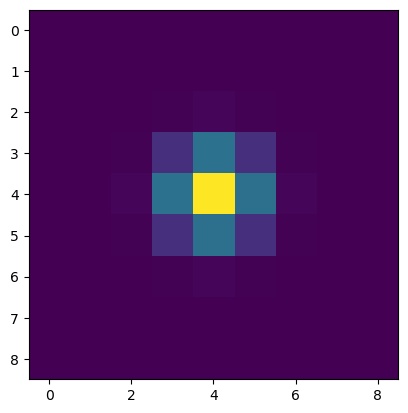

In [18]:
plt.imshow(cell_probabilities)

In [19]:
indices_array = np.array(indices_list)
relative_indices = indices_array[:,:len(cells)] - indices_array[:,len(cells):]

# Shifting the relative positions by the position of the center
center_pos = (cells / 2).astype(int)
centered_positions = relative_indices + center_pos

# Filtering to the valid centered positions
valid_positions = np.all((centered_positions >= 0) & (centered_positions < cells), axis=1)
filtered_centered_positions = centered_positions[valid_positions]
filtered_indices_array = indices_array[valid_positions]

# Gathering the cell_probabilities
odor_probabilities = np.zeros((*cells, *cells), dtype=float)
odor_probabilities[*filtered_indices_array.T] = cell_probabilities[*filtered_centered_positions.T]

In [20]:
# Generating an empty observation matrix
observations = np.zeros(((cell_count**2)+1, len(action_set), len(observation_labels)))

# Filling the "something" observations
agent_cells = indices_array[:np.prod(cells),2:]
for obs_i, agent_cell in enumerate(agent_cells):
    agent_cell_valid_indices = np.all(indices_array[:,2:] == agent_cell, axis=1)
    agent_at_source = agent_cell_valid_indices & np.all(indices_array[:,:2] == agent_cell, axis=1)
    filtered_indices = indices_array[agent_cell_valid_indices]

    # Finding and setting probabilities in the array
    probabilities = odor_probabilities[*filtered_indices.T][:,None]
    agent_cells_states = np.arange(cell_count**2)[agent_cell_valid_indices]

    observations[agent_cells_states,:,obs_i] = 1 - probabilities # Nothing
    observations[agent_cells_states,:,obs_i+len(agent_cells)] = probabilities # Something

    # Neighbouring cells when obs == source
    neighbouring_cells = agent_cell[None,:] + np.array([[1,0],[0,-1],[-1,0],[0,1]])
    neighbouring_cells_exists = np.all((neighbouring_cells >= 0) & (neighbouring_cells < cells), axis=1)
    neighbouring_cells[~neighbouring_cells_exists] = agent_cell[None,:]

    neighbouring_cells_points = np.array([[*agent_cell, *cell] for cell in neighbouring_cells])
    neighbouring_cells_indices = np.unique(np.ravel_multi_index(neighbouring_cells_points.T, (*cells, *cells)))

    state_index = np.ravel_multi_index((*agent_cell,*agent_cell), (*cells, *cells))

    if state_index in neighbouring_cells_indices:
        observations[state_index,:,obs_i] = 0.0
    observations[neighbouring_cells_indices,:,obs_i] = 1 - probabilities[obs_i] # Nothing
    observations[neighbouring_cells_indices,:,obs_i+len(agent_cells)] = probabilities[obs_i] # Something

# Goal observations
observations[-1,:,0] = 0.0
observations[:,:,-1] = 0.0
observations[-1,:,-1] = 1.0 # Goal

# Normalization
observations /= observations.sum(axis=-1)[:,:,None]

### Model

In [21]:
model = Model(
    states = state_labels,
    actions = action_labels,
    observations = observation_labels,
    transitions = transition_probabilities,
    observation_table = observations,
    end_states = [len(state_labels)-1], # The very last state is the goal state
    # start_probabilities = start_probabilities,
    seed=12131415
)

## Training Agent

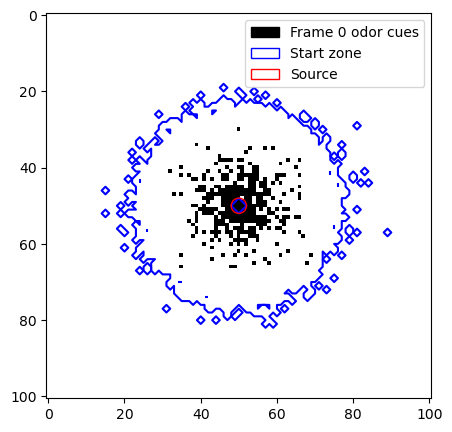

In [22]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              boundary_condition='stop',
                              start_zone='odor_present',
                              odor_present_threshold=3e-1)

artificial_env.plot()

## FSVI agent

In [23]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                space_aware=True,
                spacial_subdivisions=cells,
                model=model)

In [24]:
_ = ag.train(expansions=300, use_gpu=True)

[09/16/2024, 10:49:19] MDP_policy, not provided. Solving MDP with Value Iteration...
[09/16/2024, 10:49:19] Sending Model to GPU...
[09/16/2024, 10:49:20]     > Done in 0.781s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 6562-state, 4-action
  - Converged in 918 iterations and 1.3651 seconds
  - Took on average 0.0015s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Memory full: Out of memory allocating 37,821,268,480 bytes (allocated so far: 46,913,006,080 bytes).
Returning value function and history as is...

Summary of Point Based Value Iteration run
  - Model: 6562 state, 4 action, 163 observations
  - Converged or stopped after 180 expansion steps and 179 backup steps.
  - Resulting value function has 1105 alpha vectors.
  - Converged in 212.1519s

  - Expand function took on average 0.0135s and yielded on average 698.46 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 1.1716s and yielded on average 6.15 alpha vectors per iteration. (0.0020s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


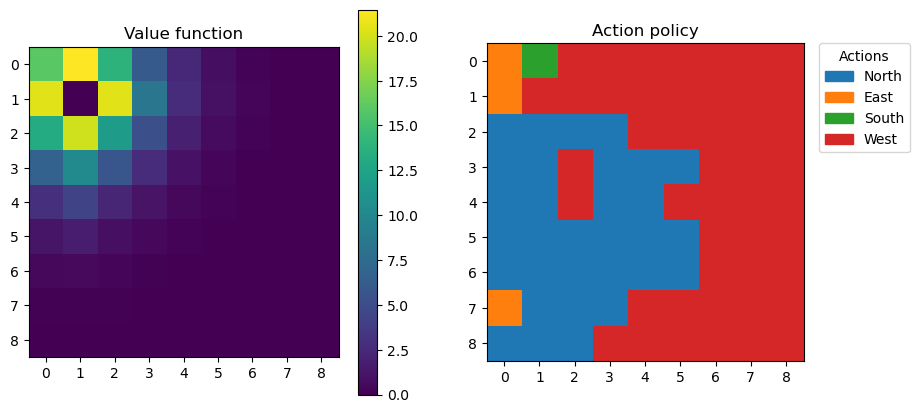

In [25]:
# CUSTOM PLOT
COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = cells

# ! Select here which source to plot
source_policy = [1,1]
source_policy_id = np.arange(cell_count).reshape(cells)[*source_policy]
source_state_start = source_policy_id * cell_count

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,source_state_start:source_state_start+cell_count]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

plt.show()

## Testing agent

In [26]:
# REPLACING WITH ARTIFICAL DATA !!
env = artificial_env
# !! Remove me

In [27]:
# Taking all starting points
start_points = np.argwhere(env.start_probabilities > 0)
n = len(start_points)

In [28]:
# From the starting points, gather what cell they came from
cell_indices_array = np.array(indices_list)
start_points_cell_ids = grid_cells[*start_points.T]
start_points_cells = cell_indices_array[:cell_count][start_points_cell_ids,2:]

In [29]:
beliefs = []

for cell in start_points_cells:
    all_source_states = np.argwhere(np.all(cell_indices_array[:,2:] == cell, axis=1))[:,0]

    # Defining start probabilities
    start_prob = np.zeros((cell_count**2)+1, dtype=float)
    start_prob[all_source_states] = 1.0
    start_prob /= np.sum(start_prob)

    # Building belief point
    belief_point = Belief(model=model, values=start_prob)
    beliefs.append(belief_point)

all_beliefs = BeliefSet(model, beliefs)

In [30]:
# Initialization of the agent
ag.belief = all_beliefs

In [31]:
hist = run_test(ag,
                n=n,
                horizon=1000,
                start_points=start_points,
                environment=env,
                # skip_initialization=True,
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 14.379s:
Simulations reached goal: 418/2340 (1922 failures (reached horizon: 1922)) (17.86% success)
 - Average step count:                 841.229 +- 343.92 (Successfull only: 111.184 +- 115.35)
 - Extra steps:                        819.672 +- 343.24 (Successful only: 90.962 +- 112.76)
 - Average discounted rewards (ADR):   0.086 +- 0.22 (Successfull only: 0.478 +- 0.30)
 - Tmin/T:                             0.084 +- 0.18 (Successful only: 0.370 +- 0.28)


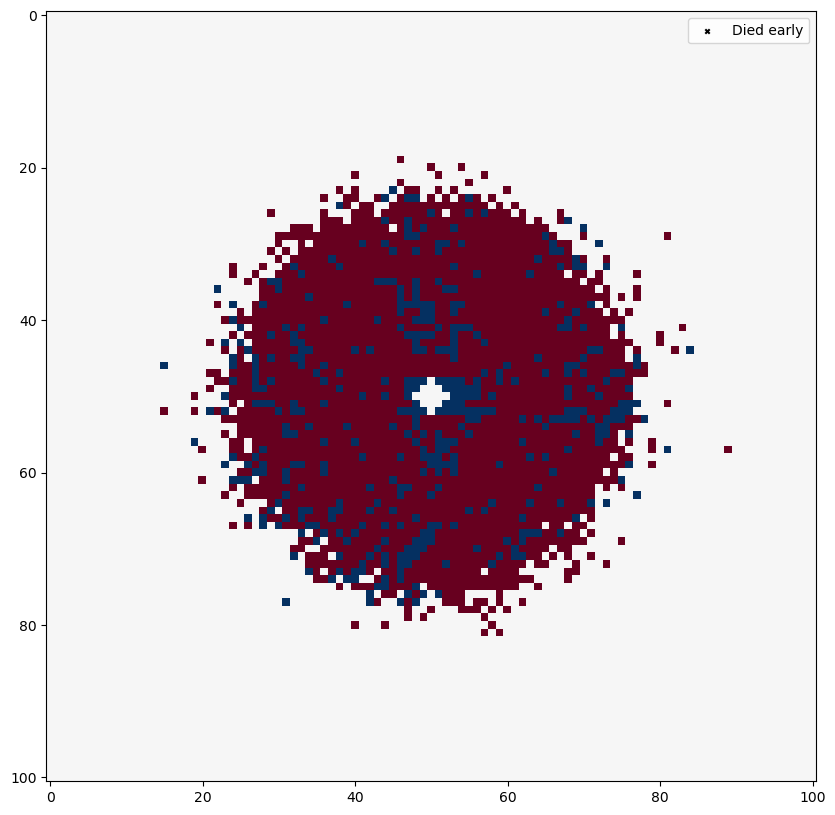

In [32]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
hist.plot_successes(ax)

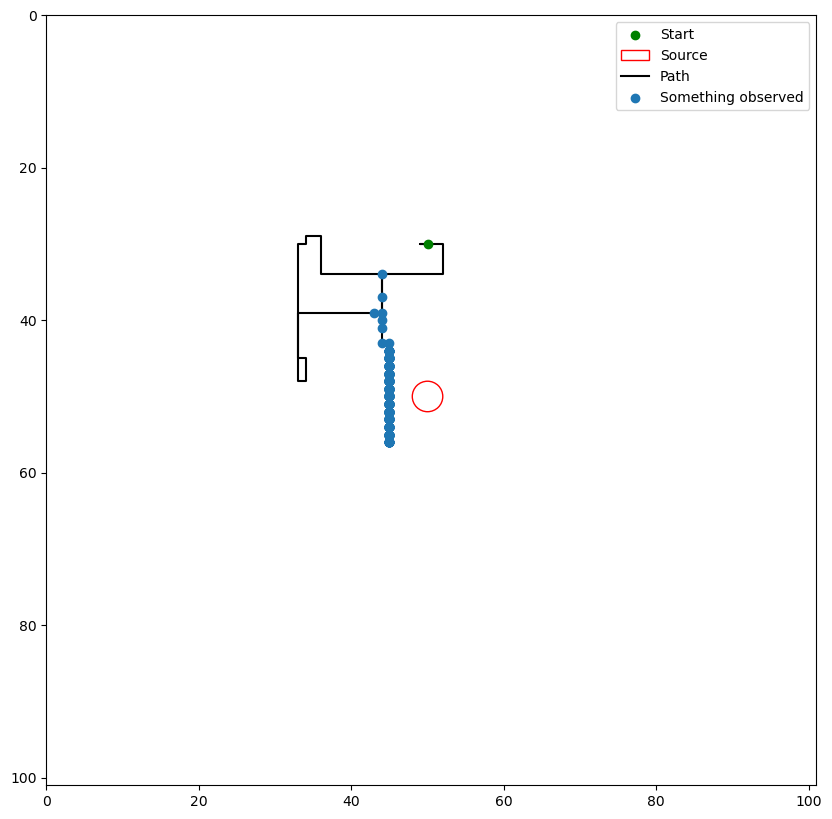

In [33]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(190, ax= ax)

In [34]:
hist.simulation_dfs[190]

,time,y,x,dy,dx,o,reached_source
0,0,30,50,None,None,None,None
1,1,30,49,0,-1,0.0,0
2,2,30,50,0,1,0.0,0
3,3,30,51,0,1,0.0,0
4,4,30,52,0,1,0.0,0
...,...,...,...,...,...,...,...
996,996,49,45,-1,0,0.0,0
997,997,48,45,-1,0,1.0,0
998,998,47,45,-1,0,1.0,0
999,999,46,45,-1,0,1.0,0


In [35]:
bs = ag.generate_beliefs_from_trajectory(hist, 19)

In [36]:
b_last = bs.belief_list[-1]

In [37]:
np.argwhere(b_last.values[:-1].reshape((*cells, *cells)))

array([[3, 4, 4, 4],
       [4, 3, 4, 4],
       [4, 4, 3, 4],
       [4, 4, 4, 3],
       [4, 4, 4, 5],
       [4, 4, 5, 4],
       [4, 5, 4, 4],
       [5, 4, 4, 4]])